# Approximation de problemes aux limites par differences finies

## $$-u''(x)+q(x)u(x) = f(x) \quad \forall x\in ]0,1[ $$
## $$u(0)=u(1)=0$$
L'inconnue est la fonction $u:[0,1]\rightarrow \mathbb{R}$.

Remarque: si $q(x)=-\pi^2\cos^2(\pi x)$ et $f(x) = \pi^2 \sin^3(\pi x)$ alors $u(x)=\sin(\pi x)$ est solution

In [1]:
######################################################
#Importer les libs de calcul matriciel et d'affichage
######################################################
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as spa
from scipy.sparse.linalg import spsolve
%matplotlib inline

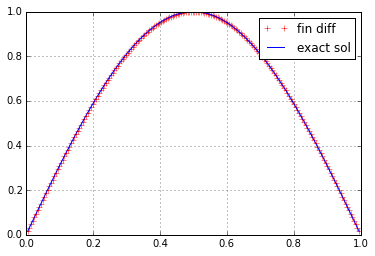

In [2]:
########################################
# Choix de la taille de discretisation
########################################
n = 200 #nombre de noeuds interieurs
h = 1./(float(n)+1.) #taille du pas Delta x 
xs = np.arange(1,n+1)*h #vecteur d'abscisses xi = i*h, i=1..N
##########################################
# Instancier les fonctions q et f du pb
###########################################
q = lambda x: -np.pi **2 * np.cos(np.pi*x) ** 2
f = lambda x: np.pi**2* np.sin(np.pi*x) ** 3
###################################################
# Assembler la matrice A et le vecteur b = h**2*F 
###################################################
A = np.diag(2*np.ones(n)+h**2*q(xs)) - np.diag(np.ones(n-1),-1) - np.diag(np.ones(n-1),1) 
b = h**2*f(xs)
###################################################
# resoudre le systeme lineaire Au=h**2 * F
###################################################
us = np.linalg.solve(A,b)
#######################################################
# Visualiser le resultat, comparer avec sol analytique
#######################################################
plt.plot(xs,us, 'r+', label = 'fin diff')
plt.plot(xs,np.sin(np.pi*xs), 'b', label='exact sol')
plt.legend()
plt.grid()

In [3]:
np.linalg.norm(us-np.sin(np.pi*xs), np.inf)

2.661377672574794e-05

# Methode de Jacobi pour resoudre $Ax=b$
### Decomposition $A=M-N$ avec  $M=D$ et $N=-(L+U)$
### Premier Itere : $x_0 \in \mathbb{R}^N$
### Suite a calculer :  $Dx_{k+1} = -(L+U)x_k +b$

In [4]:
A = spa.diags([-np.ones(n-1), 2*np.ones(n)+h**2*q(xs) , -np.ones(n-1)], [-1,0,1])
Dinv = spa.diags(1./(2*np.ones(n)+h**2*q(xs)), 0) #La diagonale
N =  -spa.diags([-np.ones(n-1),-np.ones(n-1)], [-1, 1]) #L+U, les blocs triang sup et inf
b = h**2*f(xs)

x0 = np.zeros(n) #Itere initial
iters = [x0] #On va garder la suite des iteres pour visualisation
#On garde aussi la suite de residus pour montrer la vitesse de convergence
residu = np.linalg.norm(A.dot(x0)-b)/np.linalg.norm(b)
reslist = [residu]
while residu > 1e-3:
    rhs = N.dot(x0) + b #Assembler le membre de droite
    x0 = Dinv.dot(rhs) #Resoudre un systeme trivial (D diagonale ici)
    
    residu = np.linalg.norm(A.dot(x0)-b)/np.linalg.norm(b)
    reslist +=[residu]
    iters += [x0]


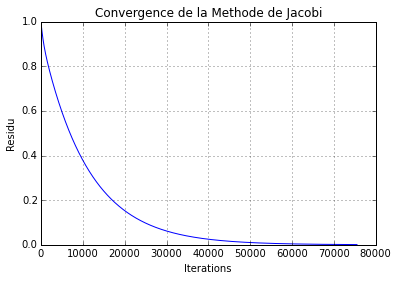

In [5]:
residues_j = np.array(reslist)
niter = residues_j.shape[0]
plt.plot(np.arange(niter),residues_j)
plt.xlabel("Iterations")
plt.ylabel("Residu")
plt.title("Convergence de la Methode de Jacobi")
plt.grid()

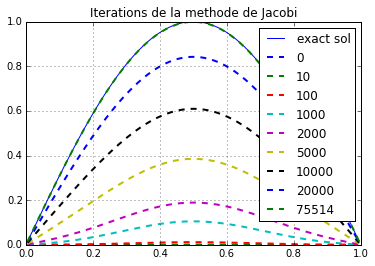

In [6]:
#Visualiser l'iteration i
plt.plot(xs,np.sin(np.pi*xs), 'b', label='exact sol')
for i in [0,10,100,1000,2000,5000,10000, 20000, niter-1]:
    plt.plot(xs,iters[i], '--',label = str(i),lw=2)
plt.title("Iterations de la methode de Jacobi")
plt.legend()
plt.grid()

Chaque iteration est peu couteuse, lineaire en n, mais il faut en faire trop. 

# Methode de Gauss Seidel pour resoudre $Ax=b$
## Decomposition $A = M-N$ avec $M=D+L$ et $N=-U$
## Suite a calculer $Mx_{k+1}=Nx_k+b$

In [7]:
A = spa.diags([-np.ones(n-1), 2*np.ones(n)+h**2*q(xs) , -np.ones(n-1)], [-1,0,1])
M = spa.diags([-np.ones(n-1), 2*np.ones(n)+h**2*q(xs)],[-1,0]).tocsr()
N = -spa.diags(-np.ones(n-1),1)

b = h**2*f(xs)

x0 = np.zeros(n) #Itere initial
iters = [x0] #On va garder la suite des iteres pour visualisation
#On garde aussi la suite de residus pour montrer la vitesse de convergence
residu = np.linalg.norm(A.dot(x0)-b)/np.linalg.norm(b)
reslist = [residu]
while residu > 1e-3:
    rhs = N.dot(x0) + b #Assembler le membre de droite
    x0 = spsolve(M,rhs) #Resoudre un systeme facile, M traingulaire
    
    residu = np.linalg.norm(A.dot(x0)-b)/np.linalg.norm(b)
    reslist +=[residu]
    iters += [x0]


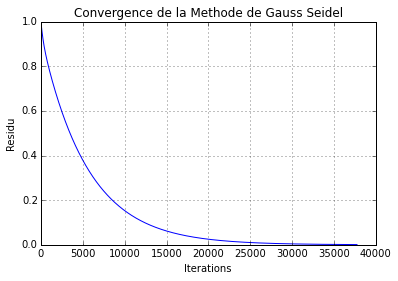

In [8]:
residues_gs = np.array(reslist)
niter = residues_gs.shape[0]
plt.plot(np.arange(niter),residues_gs)
plt.xlabel("Iterations")
plt.ylabel("Residu")
plt.title("Convergence de la Methode de Gauss Seidel")
plt.grid()

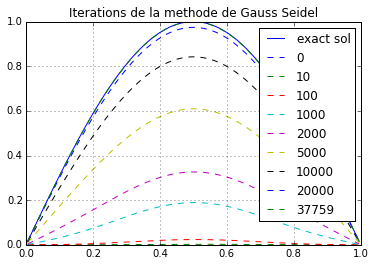

In [9]:
#Visualiser l'iteration i
plt.plot(xs,np.sin(np.pi*xs), 'b', label='exact sol')
for i in [0,10,100,1000,2000,5000,10000, 20000, niter-1]:
    plt.plot(xs,iters[i], '--',label = str(i))
plt.title("Iterations de la methode de Gauss Seidel")
plt.legend()
plt.grid()

# Methode de Richardson Stationnaire
## $x_{k+1}=(I-\alpha A)x_k +\alpha b$

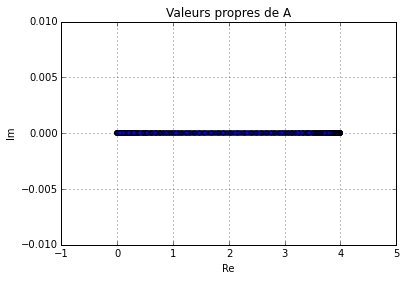

In [10]:
#Visualisation des valeurs Propres de A:
A = np.diag(2*np.ones(n)+h**2*q(xs)) - np.diag(np.ones(n-1),-1) - np.diag(np.ones(n-1),1)
valeurs_propres = np.linalg.eigvals(A)
plt.scatter(valeurs_propres.real, valeurs_propres.imag)
plt.grid()
plt.xlabel("Re")
plt.ylabel("Im")
plt.title("Valeurs propres de A")

In [11]:
print min(valeurs_propres)
print max(valeurs_propres)

0.000181244221753
3.99969649104


In [12]:
alpha = 0.25
def richardson(A,b,alpha):
    x0=np.zeros(n)
    R = spa.csr_matrix(np.eye(n)-alpha*A)
    iters=[x0]
    residu=np.linalg.norm(A.dot(x0)-b)/np.linalg.norm(b)
    residues =[residu]
    while residu>1e-3:
        x0 = R.dot(x0)+alpha*b
        residu = np.linalg.norm(A.dot(x0)-b)/np.linalg.norm(b)
        iters+=[x0]
        residues+=[residu]
    return iters, residues
iters_richardson, res_richardson = richardson(A,b,alpha)

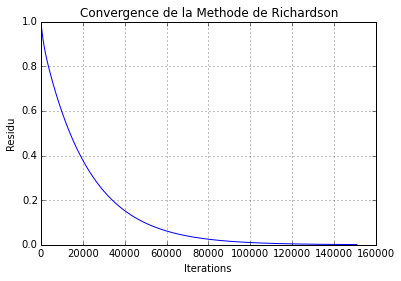

In [13]:
residues_r = np.array(res_richardson)
niter = residues_r.shape[0]
plt.plot(np.arange(niter),residues_r)
plt.xlabel("Iterations")
plt.ylabel("Residu")
plt.title("Convergence de la Methode de Richardson")
plt.grid()

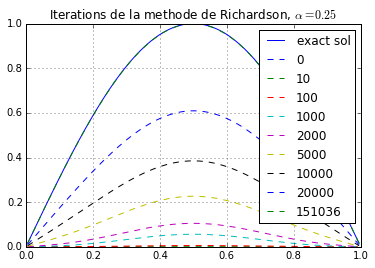

In [14]:
#Visualiser l'iteration i
plt.plot(xs,np.sin(np.pi*xs), 'b', label='exact sol')
for i in [0,10,100,1000,2000,5000,10000, 20000, residues_r.shape[0]-1]:
    plt.plot(xs,iters_richardson[i], '--',label = str(i))
plt.title(r"Iterations de la methode de Richardson, $\alpha=0.25$")
plt.legend()
plt.grid()

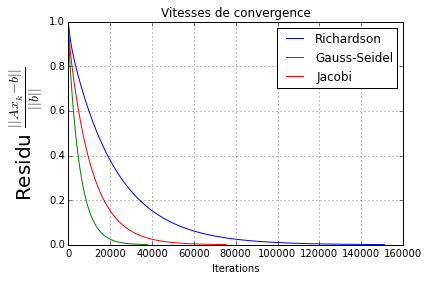

In [15]:
plt.plot(np.arange(residues_r.shape[0]),residues_r, label='Richardson')
plt.plot(np.arange(residues_gs.shape[0]),residues_gs, label='Gauss-Seidel')
plt.plot(np.arange(residues_j.shape[0]),residues_j, label='Jacobi')
plt.xlabel("Iterations")
plt.ylabel(r"Residu $\frac{||Ax_k-b||}{||b||}$", fontsize=20)
plt.title("Vitesses de convergence")
plt.legend()
plt.grid()

# Conditionnement

In [127]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
n=2
A = np.diag(2*np.ones(n)) - np.diag(np.ones(n-1),-1) - np.diag(np.ones(n-1),1) 
print A
print np.linalg.cond(A)

[[ 2. -1.]
 [-1.  2.]]
3.0


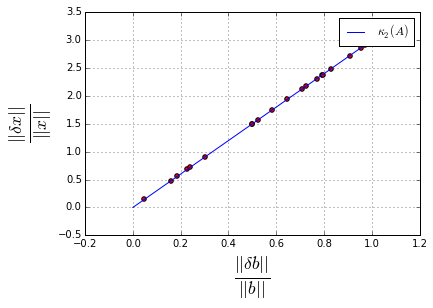

In [16]:
n=2
A = np.diag(2*np.ones(n)) - np.diag(np.ones(n-1),-1) - np.diag(np.ones(n-1),1) 
kappaA = np.linalg.cond(A)
b=np.array([np.cos(3*np.pi/4.),np.sin(3*np.pi/4.)])
#b=np.random.rand(2)
Nsamples=20
ra = np.random.rand(Nsamples)
deltabs = np.array([ra*np.cos(np.pi/4.),ra*np.sin(np.pi/4.)])
#deltabs = np.random.rand(2,Nsamples)
#deltabs = np.linspace(0,1,Nsamples)*deltab
z = np.linalg.solve(A,b)
solution_perturbation = np.zeros(Nsamples)
rhs_perturbation = np.zeros(Nsamples)
for i in range(Nsamples):
    deltaz = np.linalg.solve(A,b+deltabs[:,i])-z
    solution_perturbation[i] = np.linalg.norm(deltaz)/np.linalg.norm(z)
    rhs_perturbation[i] = np.linalg.norm(deltabs[:,i])/np.linalg.norm(b)
plt.scatter(rhs_perturbation, solution_perturbation, c='r')
plt.plot(np.linspace(0,1),kappaA*np.linspace(0,1), label=r'$\kappa_2(A)$')
plt.legend()
#plt.axis('equal')
plt.ylabel(r'$\frac{||\delta x||}{||x||}$', fontsize=25)
plt.xlabel(r'$\frac{||\delta b||}{||b||} $', fontsize=25)
plt.grid()    

### Geometriquement le conditionnement est une mesure de l'anisotropie

In [17]:
n=2
A = np.diag(2*np.ones(n)) - np.diag(np.ones(n-1),-1) - np.diag(np.ones(n-1),1) 
t = np.linspace(0,2*np.pi,100)
xs = np.array([np.cos(t),np.sin(t)])
ys = A.dot(xs)
print A
valeurs_et_vecteurs_propres =  np.linalg.eig(A)
v1 = valeurs_et_vecteurs_propres[1][0]
v2 = valeurs_et_vecteurs_propres[1][1]

[[ 2. -1.]
 [-1.  2.]]


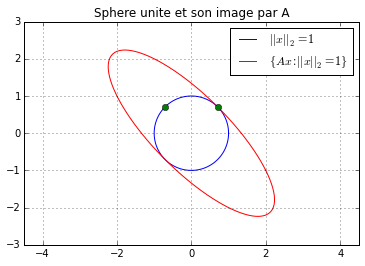

In [18]:
plt.plot(xs[0,:],xs[1,:],'b', label=r'$||x||_2=1$')
plt.plot(ys[0,:],ys[1,:], 'r', label=r'$\lbrace Ax: ||x||_2=1 \rbrace$')
plt.plot(v1[0],v1[1],'go') #vecteur propre
plt.plot(v2[0],v2[1],'go') #vecteur propre
plt.title('Sphere unite et son image par A')
plt.legend()
plt.axis('equal')
plt.grid()

## Appliquer plusieurs fois $A$ fait que l'ellipse s'applatit dans la direction propre associee a la plus grande valeur propre 

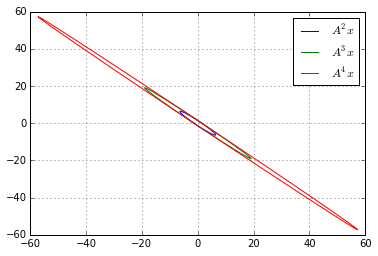

In [19]:
i=1
for k in range(3):
    ys=A.dot(ys)
    i+=1
    plt.plot(ys[0,:],ys[1,:], label=r'$A^{%d}x $'%(i))
plt.legend()
plt.grid()

## On peut d'ailleurs utiliser cette remarque pour calculer la plus grande valeur propre et le vecteur propre associe

(-1.5, 1.0, -1.0, 1.0)

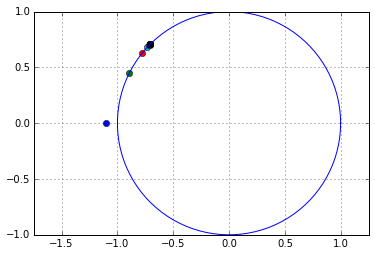

In [20]:
x=np.array([-1.1,0])
plt.plot(x[0],x[1], 'o')
for k in range(20):
    x=A.dot(x)
    x=x/np.linalg.norm(x)
    plt.plot(x[0],x[1], 'o')
plt.grid()
plt.plot(xs[0,:],xs[1,:],'b', label=r'$||x||_2=1$')
plt.axis('equal')

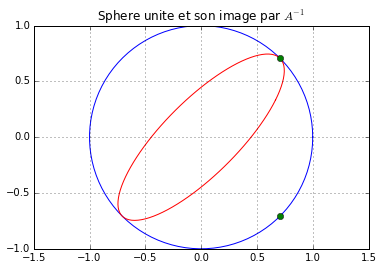

In [21]:
Ainv = np.linalg.inv(A)
valeurs_et_vecteurs_propres =  np.linalg.eig(Ainv)
v1 = valeurs_et_vecteurs_propres[1][0]
v2 = valeurs_et_vecteurs_propres[1][1]
ys = Ainv.dot(xs)
plt.plot(xs[0,:],xs[1,:],'b')
plt.plot(ys[0,:],ys[1,:], 'r')
plt.plot(v1[0],v1[1],'go') #vecteur propre
plt.plot(v2[0],v2[1],'go') #vecteur propre
plt.title(r'Sphere unite et son image par $A^{-1}$')
plt.axis('equal')
plt.grid()

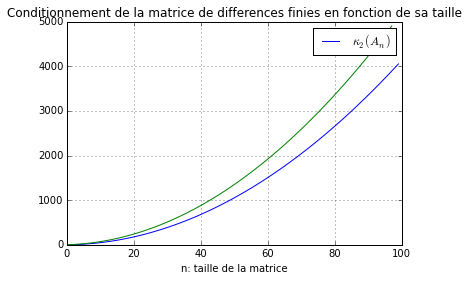

In [22]:
k=100
cond_array = np.zeros(k)
for n in range(2,k):
    A = np.diag(2*np.ones(n)) - np.diag(np.ones(n-1),-1) - np.diag(np.ones(n-1),1) 
    cond_array[n] = np.linalg.cond(A)
plt.plot(cond_array, label=r'$\kappa_2(A_n)$')
plt.plot(0.5*np.arange(2,k)**2)
plt.grid()
plt.xlabel('n: taille de la matrice')
plt.title('Conditionnement de la matrice de differences finies en fonction de sa taille')
plt.legend()